In [50]:
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
import numpy as np

In [2]:
color_map = {
    'solar': 'yellow',
    'wind': 'lightblue',
    'lithium_ion_lfp_store': 'green',
    'nuclear': 'orange',
    'natgas': 'gray',
    'oil': 'black',
    'h2_storage': 'lightpink',
    'BTES': 'darkred',
    'BTES discharger': 'darkred',
    'BTES charger': 'red',
    'load': 'darkblue'}


In [64]:
def plot_cost_scan(data_path, suffix=''):
    """
    Plot the cost scan of the BTES discharge cost
    :param data_path: path to the data
    :param suffix: suffix to add to the title and figure file name
    """
    plt.figure()
    file_names = [f for f in os.listdir(data_path) if (f.endswith('.pickle') and not 'Store' in f)]
    for btes_file in sorted(file_names, key=lambda x: float(x.split('_')[-1].split('.')[0])):

        if not btes_file.endswith('.pickle'):
            continue
        btes_discharge_cost = str(int(btes_file.split('_')[-1].split('.')[0])/1000)

        with open(os.path.join(data_path, btes_file), 'rb') as f:
            data = pickle.load(f)

            component_data = data['component results']
            cost = component_data['Capital Expenditure [$]'] + component_data['Operational Expenditure [$]']
            # Drop the first index (component type)
            cost = cost.droplevel(0)
            # Add components with same name but keep the names
            cost = cost.groupby(cost.index).sum()
            # Divide by total met demand i.e. withdrawal of load
            total_met_demand = component_data['Withdrawal [MW]']['Load'].sum()
            cost = cost / total_met_demand
            # Drop load
            cost = cost.drop('load')

            # Make stack bar plot with cost at btes_discharge_cost
            for i, (name, cost_value) in enumerate(cost.items()):
                plt.bar(btes_discharge_cost, cost_value, bottom=cost[:i].sum(), label=name, color=color_map[name])


    plt.xlabel('BTES discharge cost [$/MW]')
    plt.ylabel('Cost [$/MWh met demand]')
    plt.ylim(0, cost.sum()*1.1)

    # Add legend with unique names
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # Put legend outside of plot
    plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    if not os.path.exists('figures'):
        os.makedirs('figures')
    plt.title('4 years ISNE{0}'.format(' ' + suffix.replace('_','') if suffix else ''))
    plt.savefig('figures/btes_cost_scan{0}.png'.format(suffix), bbox_inches='tight')

    mean_demand = data['time results']['load load'].mean()
    for btes_file in sorted(file_names, key=lambda x: float(x.split('_')[-1].split('.')[0])):
        if not btes_file.endswith('.pickle'):
            continue
        btes_discharge_cost = str(int(btes_file.split('_')[-1].split('.')[0])/1000)
        # if not btes_discharge_cost == '0.25':
        #     continue

        with open(os.path.join(data_path, btes_file), 'rb') as f:
            data = pickle.load(f)
            # Make dispatch plot
            make_storage_plots(data, btes_discharge_cost, mean_demand, suffix)
            # Close pickled data
            f.close()
        

In [81]:
def make_storage_plots(result_data, btes_cost, demand, suffix):
    """
    Make plots for energy in storage and charge/discharge power
    """
    # Average over 5 days
    result_data['time results'] = result_data['time results'].resample('5D').mean()

    energy_stored_btes = result_data['time results']['granite e']/demand
    energy_stored_batteries = result_data['time results']['Lithium-Ion-LFP-store e']/demand
    energy_stored_hydrogen = result_data['time results']['hydrogen storage underground e']/demand
    
    # Create subplots where one shows energy and the other charge/discharge power
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs[0].plot(energy_stored_btes.index, energy_stored_btes, color='darkred', label='BTES')
    axs[0].plot(energy_stored_batteries.index, energy_stored_batteries, color='green', label='Batteries')
    axs[0].plot(energy_stored_hydrogen.index, energy_stored_hydrogen, color='lightpink', label='Hydrogen')

    # Axes labels and ranges
    axs[0].set_xlim(energy_stored_btes.index[0], energy_stored_btes.index[-1])
    axs[0].set_ylabel('Energy stored\nper mean demand [MWh/MW]')
    axs[0].set_xlabel('')
    axs[0].set_ylim(0, 1500)
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Plot dispatch for all technologies in the file
    dispatch = result_data['time results'].filter(like='dispatch').rename(columns=lambda x: x.replace(' dispatch', '').replace('_', ' '))
    # Rename with key in color_map if it exists
    dispatch = dispatch.rename(columns={'solar-utility': 'solar', 'onwind':'wind', 'CCGT':'natgas'})

    # Drop columns Lithium-Ion-LFP-store, electrolysis, fuel cell dispatch
    dispatch_sources = dispatch.drop(columns=['Lithium-Ion-LFP-bicharger', 'electrolysis', 'fuel cell', 'BTES charger'])
    dispatch_sources /= demand

    # dispatch_sources.plot(ax=axs[1], stacked=True, kind='area')
    dispatch_sinks = result_data['time results'][['load load', 'BTES_charger dispatch']] 
    dispatch_sinks = dispatch_sinks.rename(columns={'BTES_charger dispatch': 'BTES charger', 'load load': 'load'})
    dispatch_sinks = (dispatch_sinks/demand) * (-1)
    
    # Plot demand sources using stackplot
    y_sources = np.vstack([source for source in dispatch_sources.values.T])
    axs[1].stackplot(dispatch_sources.index, y_sources, colors=[color_map[source] for source in dispatch_sources.columns], labels=dispatch_sources.columns)
    # Plot demand sinks using stackplot
    y_sinks = np.vstack([dispatch_sinks['load'], dispatch_sinks['BTES charger']])
    axs[1].stackplot(dispatch_sinks.index, y_sinks, colors=[color_map['load'], color_map['BTES charger']], labels=['load', 'BTES charger'])
    # Make x-tick label font smaller
    plt.xticks(fontsize=8)
    # Add legend with unique names
    handles, labels = axs[1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # Put legend outside of plot
    axs[1].legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    axs[1].set_ylabel('Dispatch\nper mean demand [MW/MW]')
    axs[1].set_xlabel('Date')
    axs[1].set_ylim(-3, 3)

    

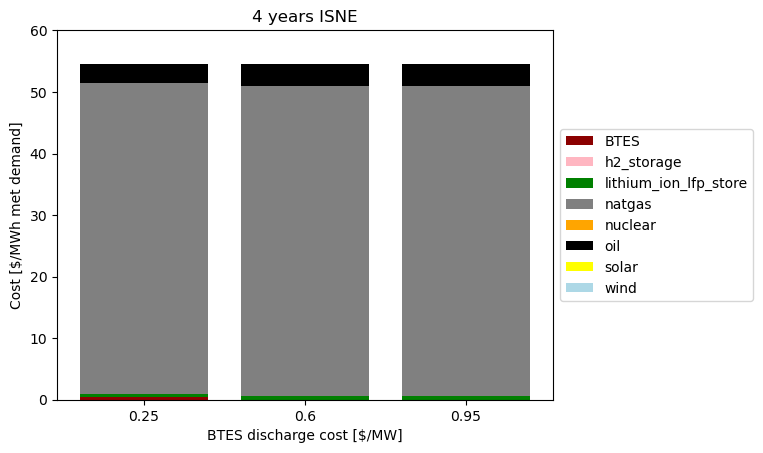

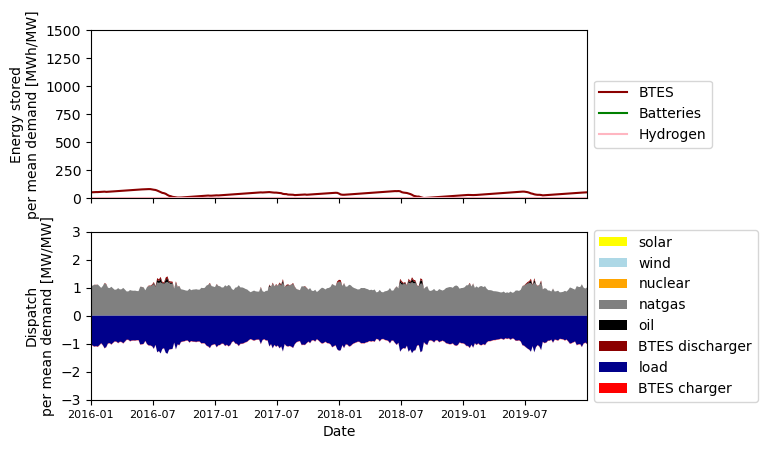

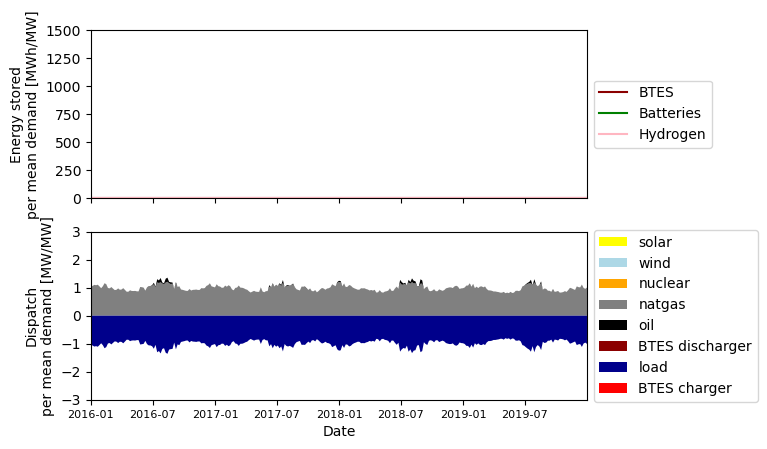

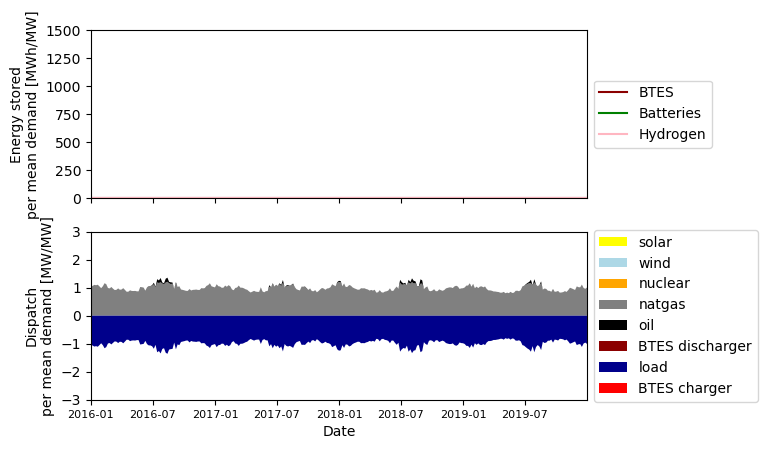

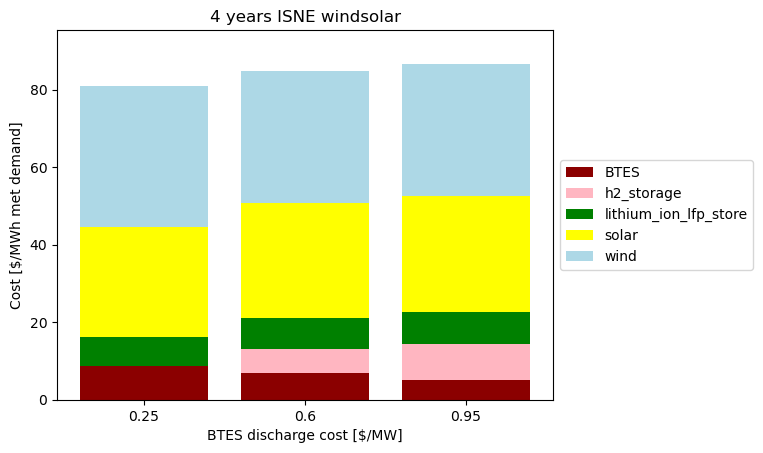

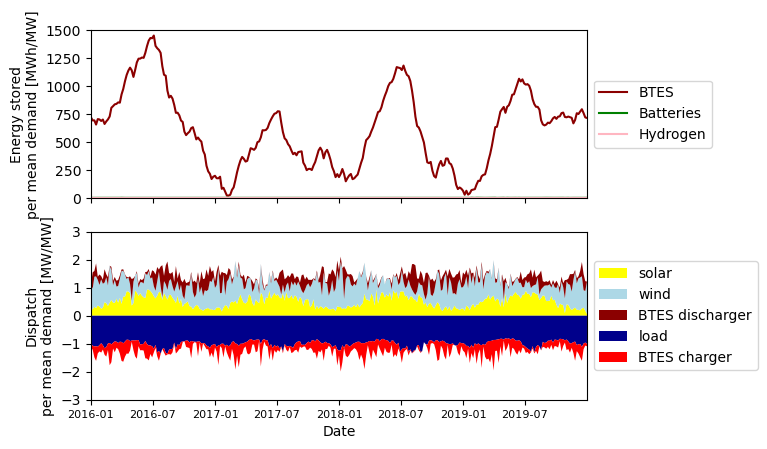

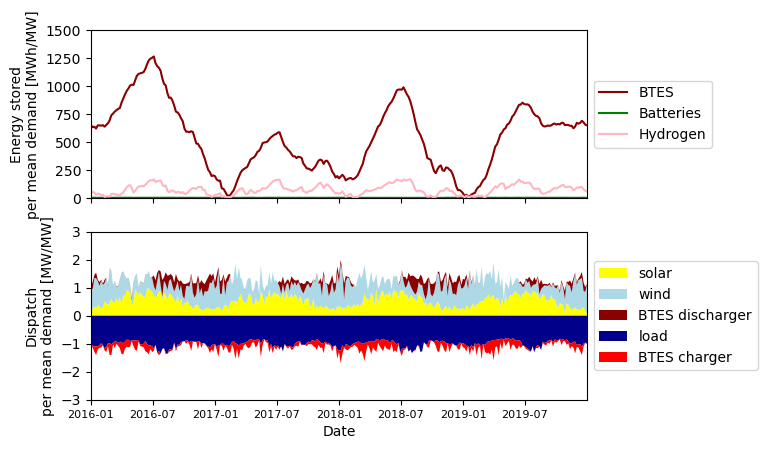

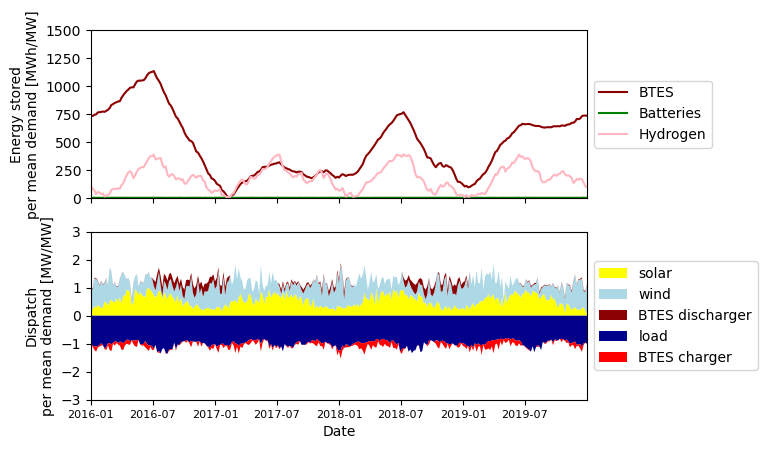

In [82]:
suffixes = ['', '_wind_solar']

for suffix in suffixes:
    output_path = 'output_data/btes_base_case_orca' + suffix

    plot_cost_scan(output_path,suffix)